In [1]:
from netCDF4 import Dataset
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from scipy.signal import argrelextrema
import pickle
import warnings

In [2]:
directory = '../data'

In [3]:
pits = pickle.load(open(f'{directory}/pickles/kuka_pits.p','rb'))

In [12]:
pits

{1: {'ka': ((14, 10, 25), (14, 10, 30)),
  'ku': ((14, 11, 15), (14, 11, 20)),
  'file': 'kuka_stare_decon_Ku-Scat20230815-141022.nc',
  'ka_hh': array([0., 0., 0., ..., 0., 0., 0.]),
  'ka_vv': array([2.30646514e-02, 2.02622764e-02, 1.35766156e-02, ...,
         8.72840766e-11, 7.91276111e-11, 7.43533814e-11]),
  'ka_hv': array([0., 0., 0., ..., 0., 0., 0.]),
  'ka_vh': array([2.30158885e-02, 2.02201243e-02, 1.35499523e-02, ...,
         1.23371515e-10, 1.28349434e-10, 1.30204618e-10]),
  'ka_range': array([-2.37      , -2.36237061, -2.35474121, ..., 13.23211182,
         13.23974121, 13.24737061]),
  'kacrosstilt': -0.5728274204514243,
  'kaalongtilt': 1.9989874362945557,
  'ku_hh': array([0., 0., 0., ..., 0., 0., 0.]),
  'ku_vv': array([2.35397858e-02, 2.06825923e-02, 1.38647684e-02, ...,
         1.46943064e-10, 1.51939694e-10, 1.53381629e-10]),
  'ku_hv': array([0., 0., 0., ..., 0., 0., 0.]),
  'ku_vh': array([2.35156314e-02, 2.06616628e-02, 1.38514581e-02, ...,
         2.2206430

In [4]:
pits_ = pits.copy()

pits = {}

for key, value in pits_.items():
    
    pits[key] = value

In [5]:
def get_ymd_from_filename(filename):
    
    datestring = filename.split('Scat')[-1][:8]
    
    y = int(datestring[:4])
    m = int(datestring[4:6])
    d = int(datestring[6:8])
    
    return(y,m,d)
def get_time_index(time,times):
    
    deltas = np.array(times) - time

    secs = np.array([d.seconds for d in deltas])
    ms = np.array([d.microseconds for d in deltas])
    
    secs = secs + (ms * 1e-6)
    
    index = np.argmin(secs)
    
    return index


def get_range_index(input_range,ranges):
    
    deltas = np.array(ranges) - input_range
    
    index = np.argmin(np.abs(deltas))
    
    return index

def get_time_ticks(times):
    seconds = [t.second for t in times]
    hours = [t.hour for t in times]
    minutes = [t.minute for t in times]
    time_ticks = [f'{h}:{str(m).zfill(2)}:{str(s).zfill(2)}' for h,m,s in zip(hours, minutes, seconds)]
    return time_ticks

In [6]:
for pitno, data_dict in pits.items():

    y,m,day = get_ymd_from_filename(pits[pitno]['file'])
    
    for freq in ['ka','ku']:

        start_time = datetime.datetime(y,m,day,data_dict[freq][0][0],data_dict[freq][0][1],data_dict[freq][0][2])
        end_time   = datetime.datetime(y,m,day,data_dict[freq][1][0],data_dict[freq][1][1],data_dict[freq][1][2])

        with Dataset(f'{directory}/ncs/{data_dict["file"]}') as d:
            ranges = np.array(d['range'])
            times = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(x)) for x in d['start_time']])

            time_ticks = get_time_ticks(times)
            hh = np.array(d['hh_power_decon0'])
            hv = np.array(d['hv_power_decon0'])
            vh = np.array(d['vh_power_decon0'])
            vv = np.array(d['vv_power_decon0'])
            
            crosstilt = np.array(d['cross_tilt'])
            alongtilt = np.array(d['along_tilt'])
       
            start_ind = get_time_index(start_time,times)
            end_ind = get_time_index(end_time,times)
            
            pits[pitno][f'{freq}_hh'] = np.mean(hh[:,start_ind:end_ind],axis=1)
            pits[pitno][f'{freq}_vv'] = np.mean(vv[:,start_ind:end_ind],axis=1)
            pits[pitno][f'{freq}_hv'] = np.mean(hv[:,start_ind:end_ind],axis=1)
            pits[pitno][f'{freq}_vh'] = np.mean(hv[:,start_ind:end_ind],axis=1)
            pits[pitno][f'{freq}_range'] = ranges
            
                 
            pits[pitno][f'{freq}crosstilt'] = np.mean(crosstilt[start_ind:end_ind])
            pits[pitno][f'{freq}alongtilt'] = np.mean(alongtilt[start_ind:end_ind])
       

In [11]:
pits.keys()

dict_keys([1, 2, 3, 4, 5, 6, 999])

In [7]:
for pitkey in pits.keys():
    
    d = pits[pitkey]
    
    for frequency in ['ku','ka']:
        
        dictionary = {}
        
        for key in d.keys():
            
            if f'{frequency}_' in key:
                
                dictionary[key] = d[key]
        
    
        df = pd.DataFrame(dictionary)
        
        df.to_csv(f'../data/csvs/{pitkey}_{frequency}_waveforms.csv')
        
#     break
    
df

,ka_hh,ka_vv,ka_hv,ka_vh,ka_range
0,2.086681e-02,2.388231e-02,2.336206e-02,2.336206e-02,-2.370000
1,1.395727e-02,2.096605e-02,2.052623e-02,2.052623e-02,-2.362371
2,6.821219e-03,1.401836e-02,1.375955e-02,1.375955e-02,-2.354741
3,2.201687e-03,6.844653e-03,6.749669e-03,6.749669e-03,-2.347112
4,3.579428e-04,2.204337e-03,2.191395e-03,2.191395e-03,-2.339482
...,...,...,...,...,...
2043,2.570692e-07,3.433016e-07,2.983015e-07,2.983015e-07,13.216853
2044,2.378923e-07,4.521837e-07,4.263150e-07,4.263150e-07,13.224482
2045,1.553810e-07,4.460342e-07,4.221517e-07,4.221517e-07,13.232112
2046,5.023254e-08,3.163051e-07,2.783679e-07,2.783679e-07,13.239741


In [8]:
tilts = []

for pitkey in pits.keys():
    
    d = pits[pitkey]
    
    dictionary = {}
    
    for key in d.keys():

        if f'tilt' in key:

            dictionary[key] = d[key]
            
    dictionary['pit_num'] = pitkey
    
    tilts.append(dictionary)

tilt_df = pd.DataFrame(tilts)

tilt_df.to_csv('../data/csvs/tilts.csv')

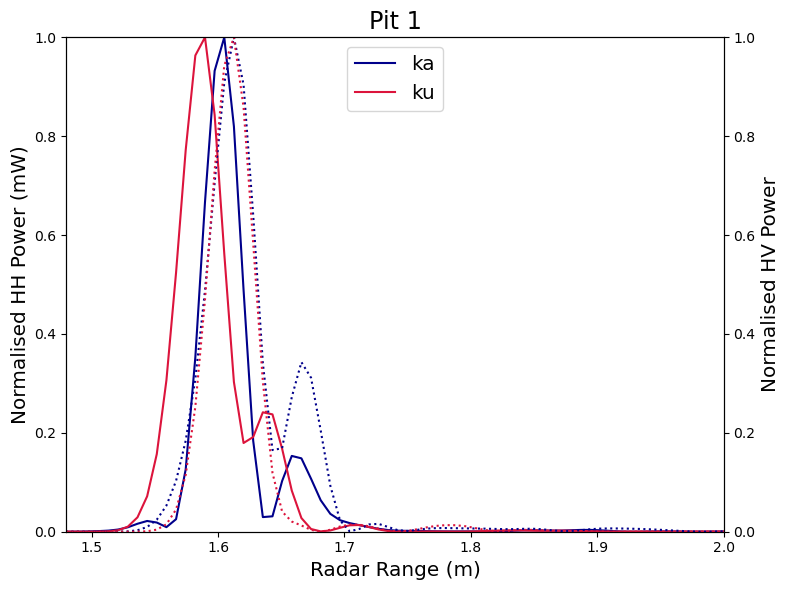

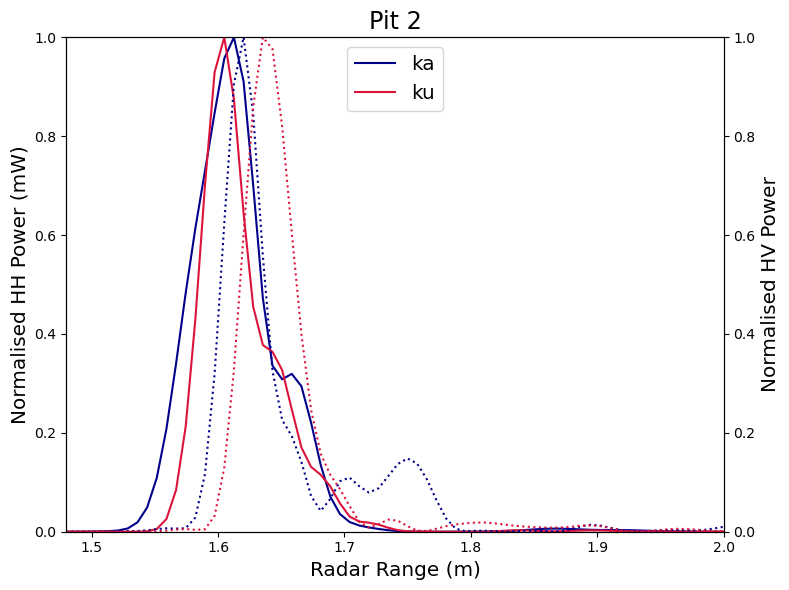

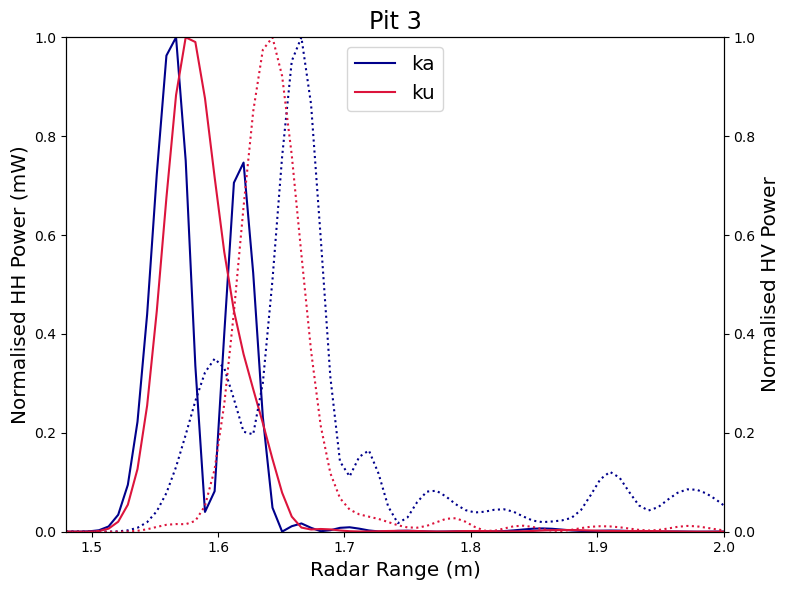

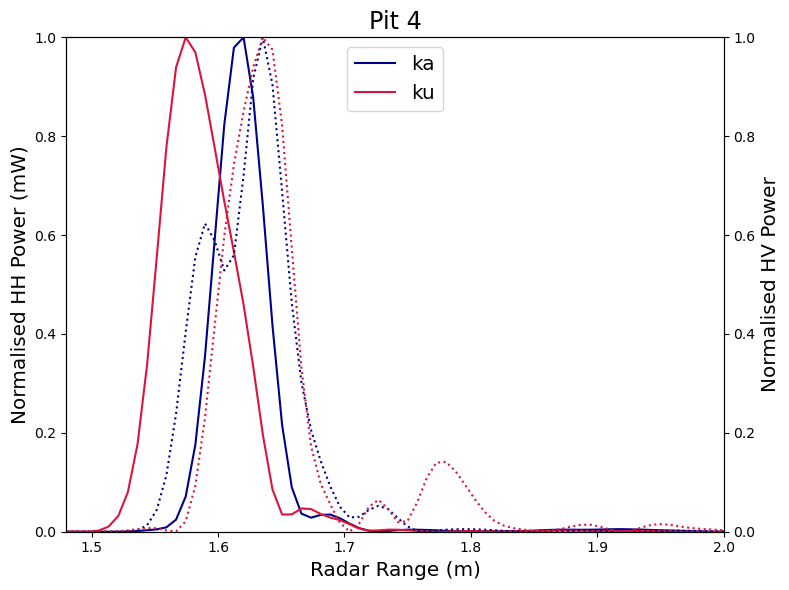

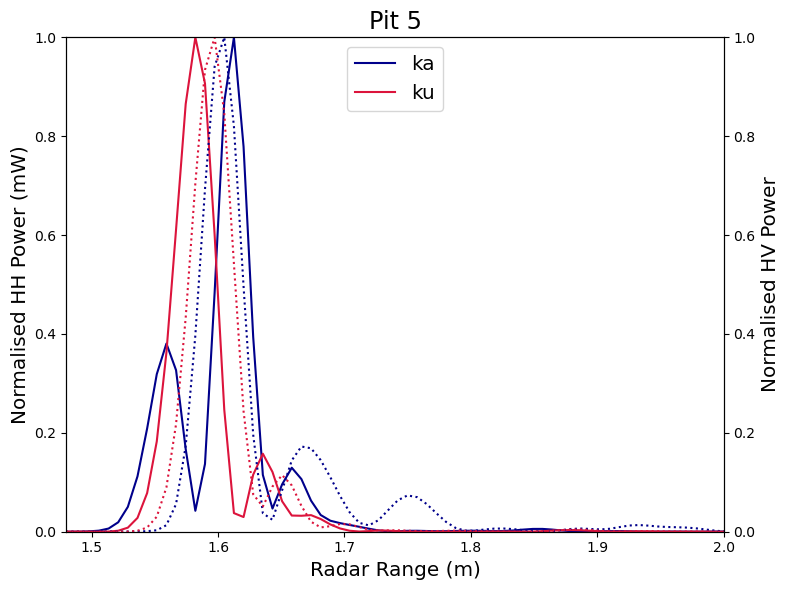

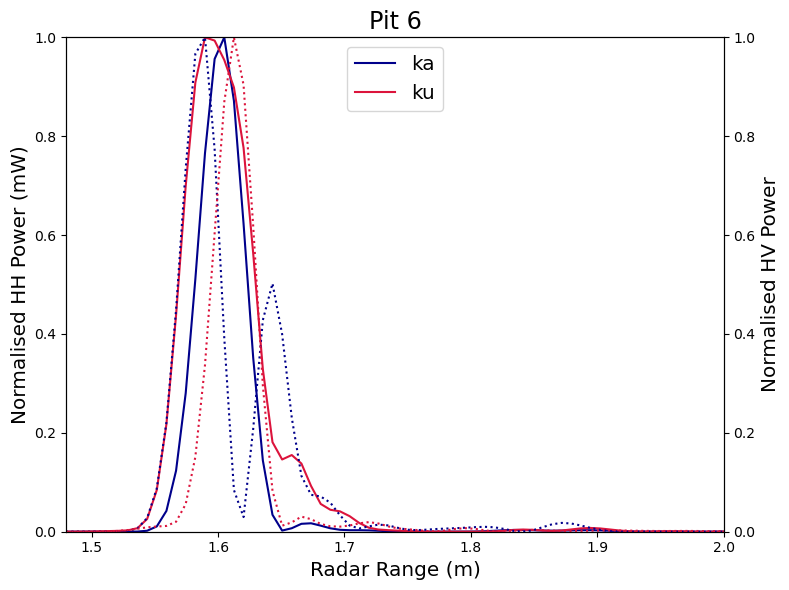

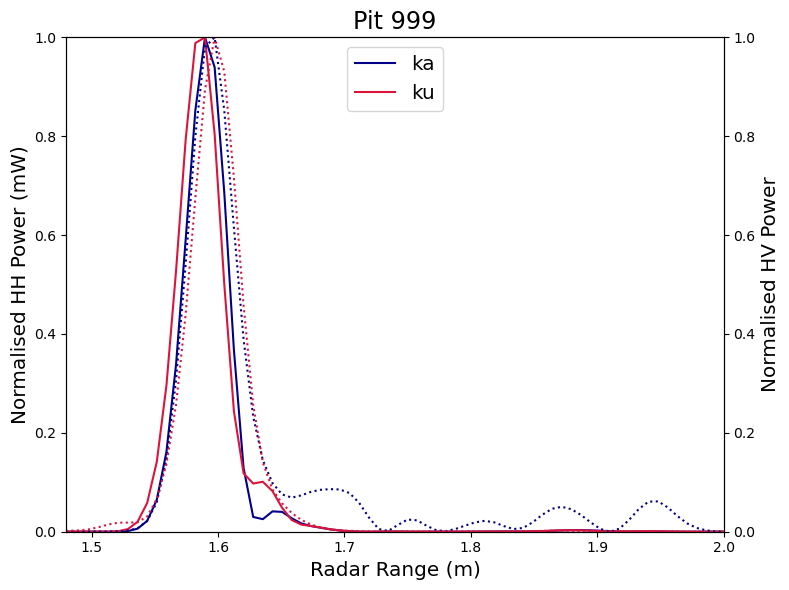

In [10]:
ylims = {'ku':0.015,'ka':0.015}

for pitno in pits.keys():
    
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    
    data_dict = pits[pitno]
    
    for freq,color in zip(['ka','ku'],['darkblue','crimson']):
        
        ranges = data_dict[f'{freq}_range']
        
        snow_line = data_dict[f'{freq}_hh']
        
        snow_line[ranges<1.2] = 0
        snow_line[ranges>4] = 0

        ax.plot(ranges,snow_line/np.max(snow_line),color=color,label=freq)
        
    ax.set_ylim(0,1)
    ax.set_ylabel(f'Normalised HH Power (mW)',fontsize='x-large')
    ax.legend(fontsize='x-large',loc='upper center')

    axb = ax.twinx()
    
    for freq,color in zip(['ka','ku'],['darkblue','crimson']):
        
        ranges = data_dict[f'{freq}_range']
        
        snow_line = data_dict[f'{freq}_hv']
        
        snow_line[ranges<1.2] = 0
        snow_line[ranges>4] = 0

        axb.plot(ranges,snow_line/np.max(snow_line),color=color,ls=':')
        
    axb.set_ylim(0,1)
    axb.set_ylabel(f'Normalised HV Power',fontsize='x-large')

    
    ax.set_xlim(1.48,2)
    ax.set_xlabel('Radar Range (m)',fontsize='x-large')
    
    plt.title(f'Pit {pitno}',fontsize='xx-large')
    
    plt.tight_layout()

    plt.savefig(f'../figures/slush_{pitno}.jpg',dpi=400)